### Demo of Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-07 13:23:09.181313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 13:23:09.283685: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-07 13:23:09.704905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-07 13:23:09.704962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-07 13:23:10.329290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 13:23:10.329500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 13:23:10.329646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 13:23:10.686492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 13:23:10.686670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [282]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 5 #10
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(804921, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

### 05- Quad With Dynamics
### 06- Dynamic Spinning

In [351]:
idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/test/frame_" + str(idx) + ".npy" #test

pc1 = np.load(fn1)

#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(gt[idx, 2:])

offset = 0#for debug 
rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# print(rot_m)

initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# pc1 = pc1 @ rot_m
# rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# pc1 = pc1 @ rotcorr
# pc1 += initial_guess[:3]

In [287]:
#code taken from KitWare pyLiDAR-SLAM library

seconds = gt[:, 0]
nano_seconds = gt[:, 1]

xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]

num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz

T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this

# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #test
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #test
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses) #try commenting out

# print(poses)
len(poses)

# from matplotlib import pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(poses[:,:,3])

1237

<IPython.core.display.Javascript object>


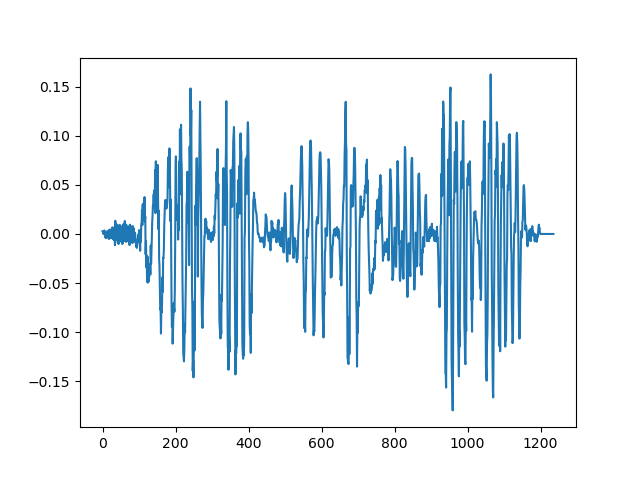

1237

In [370]:
# len(gt)
# # ans = gt[:,0] - gt[0,0]
# # ans = np.where(np.diff(gt[:,0]) > 0.99 )
# # # print(ans)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()

t = gt[:,0] + gt[:,1]/(1e9)
# ax.plot(np.diff(t)) #pretty interesting results for  dynamic spinning dataset
# ax.set_title("06- Dynamic Spinning Frame Length")
# print(np.mean(np.diff(t[100:1100])))

ax.plot(np.diff(gt[:,2]))
len(gt)

In [383]:
#register raw clouds i and j using KitWare poses

idx = 150
skip = 5 #how many lidar frames between clouds
# need to deal with how there are more LIDAR frames than ground truth poses
# offset = 10 #11  #works best for 05 dataset
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

offset = 1 #figured out through guess and check (brutal)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]

#TODO: check poses for idx corresponding to closest match

#works pretty well but not perfect
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
scan1_mapframe = scan1_mapframe[:,:3] - poses[idx][:3,3]#remove 4th column and center first scan about origin
scan2_mapframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_mapframe = initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T
submap_mapframe = submap_mapframe.T[:,:3] - poses[idx][:3,3]

disp.append(Points(scan1_mapframe, c = '#a65852',r = 2))
disp.append(Points(scan2_mapframe, c = '#2c7c94',r = 2))

disp.append(Points(submap_mapframe, c = "grey", r = 2, alpha = 0.05)) ##CB2314
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [368]:
it = ICET(cloud1 = scan1_mapframe, cloud2 = submap_mapframe, fid = 50, niter = 5, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4

 estimated solution vector X: 
 tf.Tensor([ 0.43943056 -0.14045018  0.23731942 -0.17095225 -0.4846403   0.00032002], shape=(6,), dtype=float32)

 predicted standard deviations of error: 
 tf.Tensor([0.00454032 0.00581942 0.00262239 0.00029776 0.00010965 0.00037089], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [215]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

# #matt's attempt:
# rot_m = R.from_quat(gt[idx,5:]).as_matrix()
# newscan_mapframe = (pc1 @ rot_m) + gt[idx,2:5]
# disp.append(Points(newscan_mapframe, c = 'blue',r = 2))

#kitware code
newscan_mapframe = (poses[idx] @ np.append(pc1, np.zeros([len(pc1),1]), axis=1).T).T
print(newscan_mapframe)
disp.append(Points(newscan_mapframe[:,:3], c = 'blue',r = 2))

#draw trajectory of platform according to <gt>
disp.append(Points(gt[:,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[idx+offset,2:5][None,:], r=10, c = 'red'))

#draw arrows showing heading
for i in range(50):
    rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
    arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
    disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 ...
 [13.35894007 15.3305107  -3.34722809  0.        ]
 [12.97044233 16.06148272 -3.51026981  0.        ]
 [ 0.          0.          0.          0.        ]]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


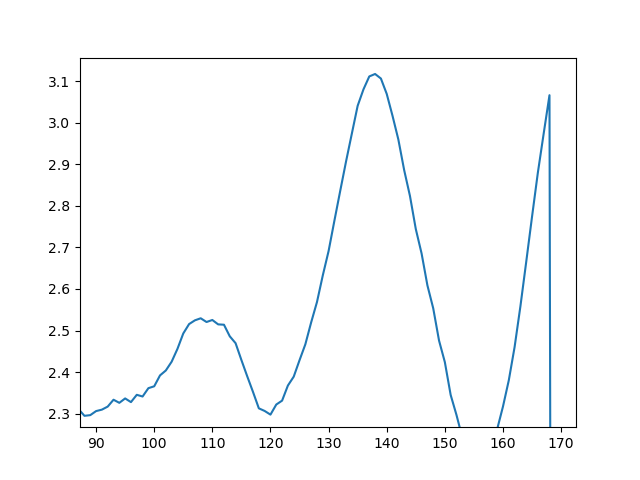

In [372]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [200]:
#transform HD Map to align with lidar frame
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]

# rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

rot = R.from_quat(gt[:,5:]).as_euler('xyz')
rot -= rot[0]
rot[:,2] = -rot[:,2]
# print(rot)
rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

map_trans = (submap - gt[idx, 2:5]) @ rot_m
disp.append(Points(pc1, c = 'blue', r = 3))
# disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

#draw axis for world frame
disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
#draw axis for world frame transformed by rot_m
disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
rot_m @ np.array([0.,0.,0.])

In [ ]:
map_trans = (submap - gt[idx, 2:5]) @ rot_m

it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
len(gt)